In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob

sys.path.append("../../../scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
%aimport plotting
%aimport umi_deduplicate

from tqdm import tqdm  # progress bar

# Sample reads to test UMI tools

In [4]:
# Build up table of UMIs and barcodes. drop duplicate rows. 
# Group by barcode and count UMIs.
# Save as csv

Using UMI-tools conda environment, ran this command to generate test

seqtk sample -s100 /global/scratch/projects/fc_mvslab/data/sequencing/20250218_MZCCSCU_MedGenome/MZ/results/assembled/AD_1_15.fastq.gz.assembled.fastq 10000 > /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15.fastq.gz.assembled.fastq

In [5]:
EC_AD_BC = finder.Barcode(name = "AD_BC",
                       preceder = "CGCGCC",
                       post = "GGGCCC",
                       length =11)

In [1]:
# TEST
# shortened from /global/scratch/projects/fc_mvslab/data/sequencing/20250218_MZCCSCU_MedGenome/MZ/results/assembled/test_AD_1_15.fastq.gz.assembled.fastq

umi_mapper = initial_map.InitialMapper(dbpath = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4.db",
                                       step_name = "umi_AD_1_15",
                                       seq_file = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15.fastq.gz.assembled.fastq",
                                       design_file_path = None,
                                       bc_objects = [ EC_AD_BC],
                                       reverse_complement = True,
                                       umi_length = 12)
umi_map = umi_mapper.create_map()
umi_map.head()

NameError: name 'initial_map' is not defined

In [14]:
# preprocess.save_parquet(umi_map, "../../../data/GCN4/test_AD_1_15.parquet")

In [7]:
# Use map refiner to only keep rows which pass AD BC qual
# Then, merge with step1 map 
test_refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4.db",
                                    bc_objects=[EC_AD_BC],
                                    column_pairs = [],
                                    reads_threshold = 1,
                                    map_order = ['quality_designed'],
                                    step_name="test_umi_1_15",
                                    descriptor = "")
test_refiner.refine_map_from_parquet( "../../../data/GCN4/test_AD_1_15.parquet/*")

Base prefix (stable across descriptors): test_umi_1_15_AD_BC_
Full prefix for this instance: test_umi_1_15_AD_BC_

Using the following step order:
1. initial
2. quality_designed

Reading initial map from ../../../data/GCN4/test_AD_1_15.parquet/* as test_umi_1_15_AD_BC_initial...
Skipping — table test_umi_1_15_AD_BC_initial already exists.
Done in 0.01 seconds.

Filtering to quality and designed...
Done in 0.01 seconds.

Done.


In [8]:
test_refiner.show_tables()

('step1_AD_AD_BC_RPTR_BC_initial',)
('step1_AD_AD_BC_RPTR_BC_initial_grouped',)
('step1_AD_AD_BC_RPTR_BC_quality_designed',)
('step1_AD_AD_BC_RPTR_BC_thresholded',)
('step1_AD_AD_BC_RPTR_BC_unique_target',)
('test_umi_1_15_AD_BC__unique_barcodes',)
('test_umi_1_15_AD_BC_initial',)
('test_umi_1_15_AD_BC_quality_designed',)
('test_umi_1_15_AD_BC_quality_designed_umis_collapsed',)
('test_umi_1_15_AD_BC_unique_barcodes',)
('umi_1_15_AD_BC_initial',)
('umi_1_15_AD_BC_quality_designed',)
('umi_1_15_AD_BC_quality_designed_umis_collapsed',)
('umi_1_15_AD_BC_unique_barcodes',)
('umi_AD_1_15_AD_BC_initial',)
('umi_AD_BC_1_15_quality_designed',)
('umi_AD_BC_initial',)
('umi_AD_BC_quality_designed',)


In [10]:
test_simple_dedup = umi_deduplicate.SimpleUMIDeduplicator(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4.db",
                                                          bc_objects = [EC_AD_BC],
                                                          step_name = "test_umi_1_15",
                                                          descriptor = "",
                                                          step_suffix = "quality_designed",
                                                          step1_map_name = "step1_AD_AD_BC_RPTR_BC_quality_designed")

In [16]:
simple_umi_results = test_simple_dedup.unique_umis_per_barcodes()#.sort_values(by = 'count')
simple_umi_results.to_csv("../../../data/simple_umi_results.csv")

Counting unique UMIs per barcode(s) and saving as test_umi_1_15_AD_BC_quality_designed_umis_collapsed...
unique_AD_BC_umis


In [18]:
# Goal is to transport to output like this
umi_map[["AD_BC", "UMI"]].drop_duplicates().groupby("AD_BC").count().reset_index()

,AD_BC,UMI
0,AAAAAAACTGA,1
1,AAAAAAAGACT,1
2,AAAAAAGACTC,2
3,AAAAAAGCCAA,1
4,AAAAAAGCTGG,1
...,...,...
7138,TTTTTGTTTAC,1
7139,TTTTTTAGTGG,1
7140,TTTTTTCCTTC,3
7141,TTTTTTTGCGC,1


# Now with the full output

In [19]:
! rm /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4/AD_1_15_reads_shortened.txt

In [5]:
umi_mapper_full = initial_map.InitialMapper(seq_file = "/global/scratch/projects/fc_mvslab/data/sequencing/20250218_MZCCSCU_MedGenome/MZ/results/assembled/AD_1_15.fastq.gz.assembled.fastq",
                                       design_file_path = None,
                                       bc_objects = [EC_AD_BC],
                                       reverse_complement = True,
                                       umi_length = 12)
AD_1_15_mapped_df = umi_mapper_full.create_map()
AD_1_15_mapped_df.head()

,AD_BC,AD_BC_qual,UMI,Designed
1,CCCAGATCTCA,True,ACGTCCCGGTNC,1
5,ACCTGTGCACG,True,CGAATGACCTNC,1
9,AACATTGTAAA,True,CTTGATGGATNT,1
13,ACCGAAGGTCG,True,CAGATGGCGTNC,1
17,GAAACCTTCCT,True,ATGAATACCTNA,1


In [6]:
preprocess.save_parquet(AD_1_15_mapped_df, "../../../data/GCN4/AD_1_15_ADBC_umi.parquet")

[####                                    ] | 10% Completed | 135.87 s



KeyboardInterrupt



In [7]:
# Use map refiner to only keep rows which pass AD BC qual
# Then, merge with step1 map 
refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4.db",
                                    bc_objects=[EC_AD_BC],
                                    column_pairs = [],
                                    reads_threshold = 1,
                                    map_order = ['quality_designed'],
                                    step_name="umi_1_15",
                                    descriptor = "")
refiner.refine_map_from_parquet("../data/GCN4/AD_1_15_ADBC_umi.parquet/*")

Base prefix (stable across descriptors): umi_1_15_AD_BC_
Full prefix for this instance: umi_1_15_AD_BC_

Using the following step order:
1. initial
2. quality_designed

Reading initial map from ../data/GCN4/AD_1_15_ADBC_umi.parquet/* as umi_1_15_AD_BC_initial...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 8.30 seconds.

Filtering to quality and designed...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 22.26 seconds.

Done.


In [8]:
refiner.show_tables()

('step1_AD_AD_BC_RPTR_BC_initial',)
('step1_AD_AD_BC_RPTR_BC_initial_grouped',)
('step1_AD_AD_BC_RPTR_BC_quality_designed',)
('step1_AD_AD_BC_RPTR_BC_thresholded',)
('step1_AD_AD_BC_RPTR_BC_unique_target',)
('umi_1_15_AD_BC_initial',)
('umi_1_15_AD_BC_quality_designed',)
('umi_AD_BC_1_15_quality_designed',)
('umi_AD_BC_initial',)
('umi_AD_BC_quality_designed',)


In [9]:
con = duckdb.connect("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4.db")

In [10]:
umi_adbc_counts = con.execute("""
    SELECT UMI, AD_BC, COUNT(*) AS read_count
    FROM umi_AD_BC_quality_designed
    GROUP BY UMI, AD_BC
    ORDER BY read_count DESC
""").fetchdf()

umi_adbc_counts

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,UMI,AD_BC,read_count
0,TTCTGGAAGAAT,GGGGCCGGCAG,101
1,CCGGACCCTCCT,CGGTTTAACTA,100
2,AGCAATCATAGG,CGATCGCAATT,95
3,AACTCAACTCGT,CAACATATCAT,93
4,AGAGCAGAACCA,CGATACGCTGA,93
...,...,...,...
8883857,CAGCCGTGACGT,AGAAAAAGCAA,1
8883858,TCCAGTTGACGT,CCTGCAGGAAC,1
8883859,TAATCGCTGAAA,GTCCACCGGAG,1
8883860,CAACTTTAACCC,ACAGTCTTATA,1


In [11]:
umi_adbc_counts["UMI"].value_counts()

UMI
AAAAAAAAAAAA    70
TTCTTATGATTT    61
TTTCTTATGATT    41
GAAAAAAAAAAA    40
TAAAAAAAAAAA    37
                ..
ACTAACGGGCGA     1
TTAGAGGAGTGT     1
GAGATTTAATGA     1
GGTATCTTTCCC     1
TCCAGTTGACGT     1
Name: count, Length: 5656150, dtype: int64

<Axes: xlabel='read_count', ylabel='Count'>

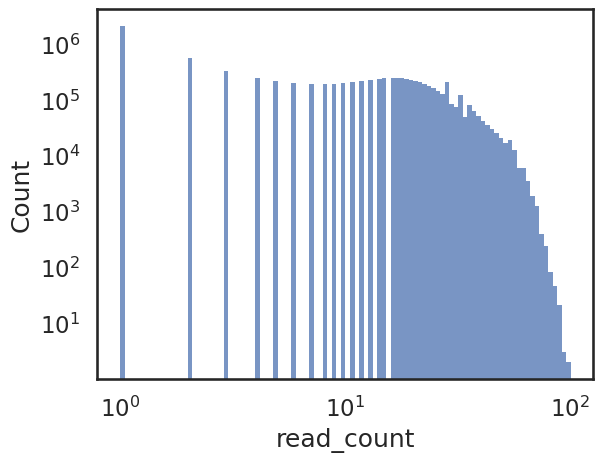

In [37]:
sns.histplot(umi_adbc_counts["read_count"], bins = 100, log_scale = (True, True), edgecolor = 'none')

In [12]:
# Count unique UMIs per AD_BC
umi_counts_per_adbc = con.execute("""
    SELECT AD_BC, COUNT(DISTINCT UMI) AS unique_umi_count
    FROM umi_AD_BC_quality_designed
    GROUP BY AD_BC
    ORDER BY unique_umi_count DESC
""").fetchdf()
umi_counts_per_adbc

,AD_BC,unique_umi_count
0,TTATTCGAATT,11616
1,CGCGGCTACAA,7224
2,AGTAACAGCTG,7211
3,GTCCGTAGGGA,5753
4,ATACCGCCAAC,5633
...,...,...
403260,CCTCGATTCAA,1
403261,GATTTTTCACA,1
403262,GAAAATTGGAC,1
403263,ATCTGTAAGAG,1


<Axes: xlabel='unique_umi_count', ylabel='Count'>

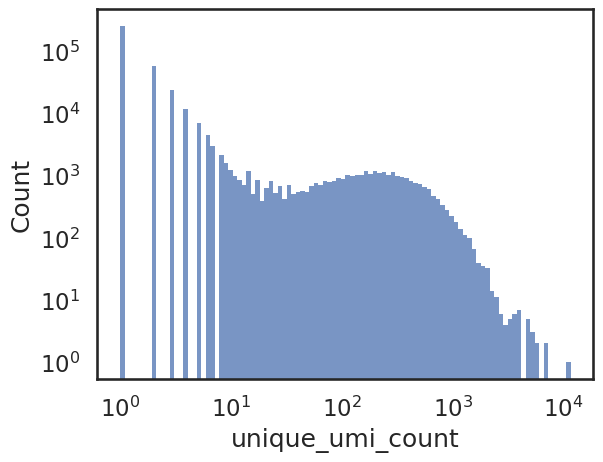

In [13]:
# Should I be removing BCs with few unique UMis?
sns.histplot(umi_counts_per_adbc["unique_umi_count"], bins = 100, log_scale = (True, True), edgecolor = 'none')

In [32]:
umi_counts_per_adbc[umi_counts_per_adbc["unique_umi_count"] > 12]

,AD_BC,unique_umi_count
0,TTATTCGAATT,11616
1,CGCGGCTACAA,7224
2,AGTAACAGCTG,7211
3,GTCCGTAGGGA,5753
4,ATACCGCCAAC,5633
...,...,...
36501,ATTGTCAAAAA,13
36502,GTGGGATTTAA,13
36503,TAACGGGTCGC,13
36504,TTAACAAGGAA,13


# Compare to Emily's UMI activities

In [44]:
# All activities from EC's demultixed UMI calcuations
concatenated_df = pd.read_csv("../../../from_EC/20250226_TREBL_MAZ06/demultiplexed_counts.csv")
concatenated_df["Time"] = concatenated_df["Library"].str.split("_").str[1]
concatenated_df["sample"] = concatenated_df["Library"].str.split("_").str[0]
concatenated_df = concatenated_df.rename(columns={"Ratio_negctrlnorm": "Ratio_negCTRLnorm",
    "UMIs_RPTR": "RPTR_UMIs",
    "UMIs_AD": "AD_UMIs"})
concatenated_df = concatenated_df[concatenated_df["Library"] == "1_15"]
concatenated_df

,Barcode_RPTR,RPTR_UMIs,Reads_RPTR,RPTR_BC,AD,AD_BC,AD_ADBC,Barcode_AD,Tile,AD_UMIs,Reads_AD,Ratio,Ratio_negCTRLnorm,Library,Time,sample
97241,ATCTATTTCGTAGA,11607,628686.0,ATCTATTTCGTAGA,CCAGAATTTGCTGATTATGATGTTTCTCCATTTATTGGTGATAATC...,CTATAGCCCTC,CCAGAATTTGCTGATTATGATGTTTCTCCATTTATTGGTGATAATC...,CTATAGCCCTC,CCAGAATTTGCTGATTATGATGTTTCTCCATTTATTGGTGATAATC...,1073,14833.0,10.817335,78.417514,1_15,15,1
97242,AATACCACCTTGCT,1570,83527.0,AATACCACCTTGCT,TTGTTGTTGCATGAACCATATTTGTCTGCTCCATCTTCTACTGCTT...,GGAGTTCCCCA,TTGTTGTTGCATGAACCATATTTGTCTGCTCCATCTTCTACTGCTT...,GGAGTTCCCCA,TTGTTGTTGCATGAACCATATTTGTCTGCTCCATCTTCTACTGCTT...,281,3886.0,5.587189,40.502902,1_15,15,1
97243,TGATTGACCCGCCC,1749,90137.0,TGATTGACCCGCCC,TCTTTGGCTACTATTTCTCCACAAGATTTGTTTGCTCATGATAACT...,GCCAAGGTAGT,TCTTTGGCTACTATTTCTCCACAAGATTTGTTTGCTCATGATAACT...,GCCAAGGTAGT,TCTTTGGCTACTATTTCTCCACAAGATTTGTTTGCTCATGATAACT...,1015,14651.0,1.723153,12.491557,1_15,15,1
97244,GTGATCATGACCAG,817,42433.0,GTGATCATGACCAG,GGTGGTGCTAATACTGCATTCTCTTCTCCAGCTGTTCCAACTGTCT...,CGTACGTTAGC,GGTGGTGCTAATACTGCATTCTCTTCTCCAGCTGTTCCAACTGTCT...,CGTACGTTAGC,GGTGGTGCTAATACTGCATTCTCTTCTCCAGCTGTTCCAACTGTCT...,489,7256.0,1.670757,12.111725,1_15,15,1
97245,TAAAAGATAGATGG,4291,224513.0,TAAAAGATAGATGG,TTGTTTCAATCTGATGATTCTGCTGTTAATGGTGCTGTTAATTGGC...,TATTCGTGCCT,TTGTTTCAATCTGATGATTCTGCTGTTAATGGTGCTGTTAATTGGC...,TATTCGTGCCT,TTGTTTCAATCTGATGATTCTGCTGTTAATGGTGCTGTTAATTGGC...,515,7173.0,8.332039,60.400995,1_15,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113612,TGATCAGCTTGATA,4,150.0,TGATCAGCTTGATA,ACTTTGGCTGCTAGAGATTCTAGACAAAGGAAATTTGATCATGTTA...,CGTTTACAGAT,ACTTTGGCTGCTAGAGATTCTAGACAAAGGAAATTTGATCATGTTA...,CGTTTACAGAT,ACTTTGGCTGCTAGAGATTCTAGACAAAGGAAATTTGATCATGTTA...,50,629.0,0.080000,0.579940,1_15,15,1
113613,ATGAAAGTGCCAAG,2,66.0,ATGAAAGTGCCAAG,GCTTTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAG...,GGATGACTTTC,GCTTTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAG...,GGATGACTTTC,GCTTTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAG...,11,144.0,0.181818,1.318045,1_15,15,1
113614,AACCAGAATTCCTG,1,1.0,AACCAGAATTCCTG,TCTTCTGTTTCTGGTGTTGGTTCTAGAAGAAGAGATAAACCATTGC...,GACGTTGTACG,TCTTCTGTTTCTGGTGTTGGTTCTAGAAGAAGAGATAAACCATTGC...,GACGTTGTACG,TCTTCTGTTTCTGGTGTTGGTTCTAGAAGAAGAGATAAACCATTGC...,370,4920.0,0.002703,0.019593,1_15,15,1
113615,TGCGGATTAAAGGA,1,106.0,TGCGGATTAAAGGA,CCAGCTGAATATGAAGGTAGATATCCATTGAGAAATTTGCAAGTTA...,ATAGAGCTTCG,CCAGCTGAATATGAAGGTAGATATCCATTGAGAAATTTGCAAGTTA...,ATAGAGCTTCG,CCAGCTGAATATGAAGGTAGATATCCATTGAGAAATTTGCAAGTTA...,77,984.0,0.012987,0.094146,1_15,15,1


In [46]:
concatenated_df[["Barcode_AD", "AD_UMIs"]]

,Barcode_AD,AD_UMIs
97241,CTATAGCCCTC,1073
97242,GGAGTTCCCCA,281
97243,GCCAAGGTAGT,1015
97244,CGTACGTTAGC,489
97245,TATTCGTGCCT,515
...,...,...
113612,CGTTTACAGAT,50
113613,GGATGACTTTC,11
113614,GACGTTGTACG,370
113615,ATAGAGCTTCG,77


In [47]:
umi_counts_per_adbc

,AD_BC,unique_umi_count
0,TTATTCGAATT,11616
1,CGCGGCTACAA,7224
2,AGTAACAGCTG,7211
3,GTCCGTAGGGA,5753
4,ATACCGCCAAC,5633
...,...,...
403260,GCGGAGCGTAA,1
403261,GGAGACATAGA,1
403262,NCGTCNGCTTT,1
403263,ANANTTNTGTT,1


In [61]:

EC_SK_comparison = pd.merge(umi_counts_per_adbc, concatenated_df[["Barcode_AD", "AD_UMIs"]], left_on = "AD_BC", right_on = "Barcode_AD")
EC_SK_comparison

,AD_BC,unique_umi_count,Barcode_AD,AD_UMIs
0,TTATTCGAATT,11616,TTATTCGAATT,11425
1,CGCGGCTACAA,7224,CGCGGCTACAA,7078
2,AGTAACAGCTG,7211,AGTAACAGCTG,7049
3,GTCCGTAGGGA,5753,GTCCGTAGGGA,5604
4,ATACCGCCAAC,5633,ATACCGCCAAC,5452
...,...,...,...,...
16295,TTTGGCTATAG,1,TTTGGCTATAG,1
16296,GTCCACCCCGT,1,GTCCACCCCGT,142
16297,TCAAGGCATGT,1,TCAAGGCATGT,1
16298,CACGCGACCGC,1,CACGCGACCGC,21


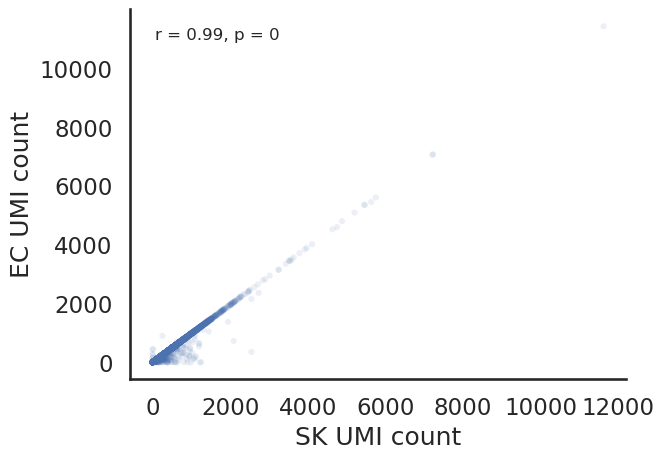

In [64]:
# overall look similar
# The differences might be because I used preceding/post sequences while Emily used the location
from scipy.stats import pearsonr

# Scatter plot
sns.scatterplot(
    data=EC_SK_comparison, 
    x="unique_umi_count", 
    y="AD_UMIs", 
    edgecolor='none', 
    s=20, 
    alpha=0.1
)

# Compute Pearson correlation
corr, pval = pearsonr(EC_SK_comparison["unique_umi_count"], EC_SK_comparison["AD_UMIs"])

# Annotate correlation on the plot
plt.text(
    0.05, 0.95, f"r = {corr:.2f}, p = {pval:.2g}", 
    transform=plt.gca().transAxes, 
    fontsize=12, 
    verticalalignment='top'
)

plt.xlabel("SK UMI count")
plt.ylabel("EC UMI count")
sns.despine()
plt.show()

In [58]:
# Many cases where I count more UMIs than emily. maybe my prefix/post search is more flexible and makes more reads usable?
EC_SK_comparison[EC_SK_comparison["unique_umi_count"] > EC_SK_comparison["AD_UMIs"]]

,AD_BC,unique_umi_count,Barcode_AD,AD_UMIs
0,TTATTCGAATT,11616,TTATTCGAATT,11425
1,CGCGGCTACAA,7224,CGCGGCTACAA,7078
2,AGTAACAGCTG,7211,AGTAACAGCTG,7049
3,GTCCGTAGGGA,5753,GTCCGTAGGGA,5604
4,ATACCGCCAAC,5633,ATACCGCCAAC,5452
...,...,...,...,...
16220,TATAGCGACAT,3,TATAGCGACAT,2
16222,ACATCCACTCC,3,ACATCCACTCC,1
16227,GTTATGGGTAC,3,GTTATGGGTAC,2
16230,AGAATCAGTAA,2,AGAATCAGTAA,1


In [60]:
# Less common for Emily to ocunt more UMIs than me but it happens
EC_SK_comparison[EC_SK_comparison["unique_umi_count"] < EC_SK_comparison["AD_UMIs"]]

,AD_BC,unique_umi_count,Barcode_AD,AD_UMIs
991,TAAATAAAACC,785,TAAATAAAACC,795
1106,CTTACTGATCC,750,CTTACTGATCC,774
1275,CCCGCATCTAC,705,CCCGCATCTAC,706
1323,CAAAACCATAT,690,CAAAACCATAT,693
1702,TGTTGGCGCGA,619,TGTTGGCGCGA,701
...,...,...,...,...
16284,TAAAATTTAGG,1,TAAAATTTAGG,2
16285,AAACCCTTTAC,1,AAACCCTTTAC,255
16294,CGAGCTGATGG,1,CGAGCTGATGG,5
16296,GTCCACCCCGT,1,GTCCACCCCGT,142


In [68]:
con.close()

In [22]:
demultiplexer = simple_umi_demultiplex.SimpleUMIDemultiplexer(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4.db",
                                                              bc_objects = [EC_AD_BC],
                                                              step_name = "umi_1_15",
                                                              descriptor = "",
                                                              step_suffix = "quality_designed",
                                                              step1_map_name = "step1_AD_AD_BC_RPTR_BC_quality_designed",
                                                             output_path = "../../../output/GCN4/")

In [25]:
demultiplexer.get_step1_map_with_umi_counts()

Counting unique UMIs per barcode(s) and saving as umi_1_15_AD_BC_quality_designed_umis_collapsed...
unique_AD_BC_umis
Saved to ../../../output/GCN4/step1_map_with_umi_1_15.csv


,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,unique_AD_BC_umis,info
0,CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...,TTATTCGAATT,TCGAACACGGCTTC,138,True,True,True,1,11616,umi_1_15
1,TCTTCTTCATTTGGTTTGTCTGGTAATTCTTCTCAACATAGATTGT...,CGCGGCTACAA,GGAGGGGTCAGAAG,194,True,True,True,1,7224,umi_1_15
2,TTTCCACCATCTTCTCCATCTATGACTACTGAAATGGTTTCTTTGC...,AGTAACAGCTG,CTTGACTAAAATCA,64,True,True,True,1,7211,umi_1_15
3,AATACATTTCATTCTGCTTATTCTTCTCCAGCTGTTCCAACTTTGT...,ATACCGCCAAC,ATCAGCCTTCCAAA,63,True,True,True,1,5633,umi_1_15
4,AGACCAGCTAGACCACCAGTTCCATTGTTCTCTCAATCTACTGGTT...,TCCTAAGCTCG,CCCCAGACTCGTTG,261,True,True,True,1,5467,umi_1_15
...,...,...,...,...,...,...,...,...,...,...
37970,ACTCAATCTACTTGGCCACCATCTTCTTCTTCTTCTCAACCAGCTC...,TGACACCCCAA,CCCTGCCCTCCTGG,41,True,True,True,1,1,umi_1_15
37971,GACCCAAGACCATTTACTATGTCTCCAGATATGTTGGATATGCAAA...,AAAACAAATAG,CATATGTCCACGTT,38,True,True,True,1,1,umi_1_15
37972,CACTTTGATGTTTCTCCATTTGTTGGTGATGGTGATTTGGATCAAT...,AGCCCTGCCGC,CCCCCCACAACGTT,57,True,True,True,1,1,umi_1_15
37973,TCTACTTCTTCTGATCCAAATACTTGGACTTCTTTGTTTGATGATG...,GCTTCCCCTTA,TCAACAGAATACTC,66,True,True,True,1,1,umi_1_15


In [26]:
pd.read_csv("../../../output/GCN4/step1_map_with_umi_1_15.csv")

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,unique_AD_BC_umis,info
0,CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...,TTATTCGAATT,TCGAACACGGCTTC,138,True,True,True,1,11616,umi_1_15
1,TCTTCTTCATTTGGTTTGTCTGGTAATTCTTCTCAACATAGATTGT...,CGCGGCTACAA,GGAGGGGTCAGAAG,194,True,True,True,1,7224,umi_1_15
2,TTTCCACCATCTTCTCCATCTATGACTACTGAAATGGTTTCTTTGC...,AGTAACAGCTG,CTTGACTAAAATCA,64,True,True,True,1,7211,umi_1_15
3,AATACATTTCATTCTGCTTATTCTTCTCCAGCTGTTCCAACTTTGT...,ATACCGCCAAC,ATCAGCCTTCCAAA,63,True,True,True,1,5633,umi_1_15
4,AGACCAGCTAGACCACCAGTTCCATTGTTCTCTCAATCTACTGGTT...,TCCTAAGCTCG,CCCCAGACTCGTTG,261,True,True,True,1,5467,umi_1_15
...,...,...,...,...,...,...,...,...,...,...
37970,ACTCAATCTACTTGGCCACCATCTTCTTCTTCTTCTCAACCAGCTC...,TGACACCCCAA,CCCTGCCCTCCTGG,41,True,True,True,1,1,umi_1_15
37971,GACCCAAGACCATTTACTATGTCTCCAGATATGTTGGATATGCAAA...,AAAACAAATAG,CATATGTCCACGTT,38,True,True,True,1,1,umi_1_15
37972,CACTTTGATGTTTCTCCATTTGTTGGTGATGGTGATTTGGATCAAT...,AGCCCTGCCGC,CCCCCCACAACGTT,57,True,True,True,1,1,umi_1_15
37973,TCTACTTCTTCTGATCCAAATACTTGGACTTCTTTGTTTGATGATG...,GCTTCCCCTTA,TCAACAGAATACTC,66,True,True,True,1,1,umi_1_15


# Repeat with RPTR reads

In [24]:
glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/*")

['/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/RPTR_1_5_S2_R1_001.fastq.gz',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/RPTR_1_30_S5_R1_001.fastq.gz',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/RPTR_2_180_S13_R1_001.fastq.gz',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/RPTR_1_180_S6_R1_001.fastq.gz',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/RPTR_3_180_S20_R1_001.fastq.gz',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/RPTR_3_0_S15_R1_001.fastq.gz',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/RPTR_3_5_S16_R1_001.fastq.gz',
 '/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_T

In [10]:
EC_RPTR_BC = finder.Barcode(name="RPTR_BC",
                           preceder="CTCGAG",
                           post="GGCCGC",
                           length=14)

In [19]:
umi_mapper_full = initial_map.InitialMapper(seq_file =  "../../../data/RPTR_1_15_S4_R1_001_reads_shortened.txt",
                                       design_file_path = None,
                                       bc_objects = [EC_RPTR_BC],
                                       reverse_complement = True,
                                       umi_length = 12)
RPTR_1_15_mapped_df = umi_mapper_full.create_map()
RPTR_1_15_mapped_df.head(20)

,RPTR_BC,RPTR_BC_qual,UMI,Designed
0,TAAAGCGCCGGAGC,True,AGTCCTCGACAA,1
1,<NA>,False,ATACAATCCGGT,1
2,CTGACTCAATACAA,True,GCGGGGGGAATG,1
3,GTCCAGTTTAGTGA,True,AGCTATAAATAT,1
4,TTCATCAATTCGAC,True,ATTGGGAACTGA,1
5,GCCTCATATTCACC,True,AGCACGTGTCTC,1
6,TAGATGATAAACAA,True,AGTGTGGCACAT,1
7,TATGACTTGACACT,True,ACCCGATTGTTG,1
8,TTGAATTAGAAACA,True,TAACGGTTAAAG,1
9,TTAATCTCGACGGT,True,CCTTTGCACTTC,1


In [17]:
preprocess.save_parquet(RPTR_1_15_mapped_df, "../../../data/GCN4/RPTR_1_15.parquet")


[########################################] | 100% Completed | 48m 34s


In [ ]:
refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4.db",
                                    bc_objects=[EC_RPTR_BC],
                                    column_pairs = [],
                                    reads_threshold = 1,
                                    map_order = ['quality_designed'],
                                    step_name="umi_1_15",
                                    descriptor = "")
refiner.refine_map_from_parquet("../../../data/GCN4/RPTR_1_15.parquet/*")